In [1]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np
import sys

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn import metrics

from sklearn.model_selection import ShuffleSplit

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
import multiprocessing

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import enchant
pd.set_option('display.max_rows', 500)

In [2]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

manualtag=pd.read_csv(Path+'SamplesManualTagger.csv')

varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

In [3]:
## if it is interdiscipilinary then -1 otherwise 0 (Normal data)
manualtag['interdiscipilinary']=-1
manualtag.loc[manualtag.apply(lambda x: (x['Category']==x['Category_1']) & (pd.isnull(x['Category_2'])) , axis=1),'interdiscipilinary']=1

## 1.1 Word Embedding

In [4]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list           
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [5]:
## creating a tagged document
DescDict=make_bigram([[x for x in str(i).split()] for i in df.PreProcessedDescription])

tagged_value = list(create_tagged_document(DescDict))

In [6]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=multiprocessing.cpu_count())

#### Hyper parameter ####
## vector_size  – Dimensionality of the feature vectors.
## If dm=1, ‘distributed memory’ (PV-DM) (CBOW - similar to continuous bag-of-words)
## alpha - The initial learning rate.
## min_count – Ignores all words with total frequency lower than this.

# Build the Volabulary
model.build_vocab(tagged_value)

model.train(tagged_value, total_examples=len(tagged_value), epochs=40)

print(str(datetime.datetime.now()),'Completed')

2020-02-23 11:41:18.137936 Started
2020-02-23 11:48:31.666789 Completed


In [7]:
## Validating the model response for random words 

modelchecked=model
target_word='laptop'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=20), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'laptop' model: Doc2Vec(dm/m,d50,n5,w5,mc5,s0.001,t4) similar words:
    1. 0.84 'consumer electronic'
    2. 0.81 'notify'
    3. 0.80 'mirror surface'
    4. 0.80 'additional measure'
    5. 0.78 'mmw'
    6. 0.76 'multiprocessor'
    7. 0.76 'operating frequency'
    8. 0.76 'goniometer'
    9. 0.76 'capacity available'
    10. 0.76 'communication infrastructure'
    11. 0.76 'microcontroller'
    12. 0.76 'cryo probe'
    13. 0.76 'longer guarantee'
    14. 0.75 'term flexibility'
    15. 0.75 'mobile system'
    16. 0.75 'busy'
    17. 0.75 'mention requirement'
    18. 0.75 'stable reliable'
    19. 0.74 'aerial vehicle'
    20. 0.74 'base station'


## 1.2. PCA

In [8]:
## PCA - reducing the dimenstion
ps=20
pcamodel = PCA(n_components=ps)
pca=pcamodel.fit_transform(model.docvecs.vectors_docs)
print('PCA components :',ps,'Variance coveragence' ,np.max(pcamodel.explained_variance_ratio_.cumsum())*100)

PCA components : 20 Variance coveragence 76.9777238368988


In [41]:
dummies=pd.get_dummies(df['Category'])
merged_data=pd.concat([df,dummies], axis=1,ignore_index=False)

merged_data=pd.concat([merged_data,pd.DataFrame(pca)], axis=1,ignore_index=False)

SubjectAreaIds=pd.DataFrame(enumerate(merged_data.SubjectArea.unique()),columns=['SubjectAreaId','SubjectArea2'])
finalcols=merged_data.columns.tolist()+['SubjectAreaId']
merged_data=merged_data.merge(SubjectAreaIds, how='left',left_on='SubjectArea',right_on='SubjectArea2')[finalcols]

merged_data=merged_data[pd.isnull(merged_data["Category"])==False]
merged_data['ISOForestCluster']=1

# 2. ISO Forest 

In [42]:
cat='Life Sciences'
FeatureCols=list(range(ps))

CategoricalDS=merged_data[FeatureCols][merged_data.Category==cat]

In [11]:
# n_estimators (default=100)    - The number of base estimators in the ensemble.
# max_samples  (default=”auto”) - The number of samples to draw from X to train each base estimator. If max_samples is larger than the number of samples provided, all samples will be used for all trees (no sampling)
# max_features (default=1.0)    - The number of features to draw from X to train each base estimator.
# contamination(default=’auto’) - The proportion of outliers in the data set. If float, the contamination should be in the range [0, 0.5].
# bootstrap (default=False)     - If True, individual trees are fit on random subsets of the training data sampled with replacement. If False, sampling without replacement is performed.
param_dict={'contamination': ['auto',.1,.2],'n_estimators': list(range(1, 100, 5)),'max_features': [10,15,20], 'max_samples': ['auto']}

In [26]:
i_category=[]
i_contamination=[]
i_n_estimators=[]
i_max_features=[]
silhouette_scores=[]
number_outliers=[]
recalls=[]

FeatureCols=list(range(ps))

for cat in merged_data.Category.unique():
    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    e=0
    for contamination in param_dict['contamination']:
        for n_estimators in param_dict['n_estimators']:
            for max_features in param_dict['max_features']:

                clusterer = IsolationForest(behaviour='new', bootstrap=False, contamination=contamination,
                    max_features=max_features, max_samples='auto', n_estimators=n_estimators, n_jobs=None,
                    verbose=0, warm_start=False, random_state=np.random.RandomState(42))
                preds = clusterer.fit_predict(CategoricalDS)
                pred_uniq=len(pd.Series(preds).unique())
                
                merged_data.loc[merged_data.Category==cat,'ISOForestCluster']=preds
                noo=merged_data.loc[(merged_data.Category==cat) & (merged_data.ISOForestCluster==-1),'ISOForestCluster'].count()

                if((pred_uniq==2) and (noo>300) and (noo<2000) ) :
                    score = silhouette_score(CategoricalDS, preds, metric='euclidean')

                    manualtag_result_1=manualtag[manualtag.Category==cat][['Translates', 'Category_1', 'Category_2','interdiscipilinary']].merge(merged_data,how='left', left_on='Translates', right_on='Translates')[['Translates', 'Category_1', 'Category_2','interdiscipilinary','ISOForestCluster']]           
                    recall=round(metrics.recall_score(manualtag_result_1.interdiscipilinary, manualtag_result_1.ISOForestCluster, pos_label=-1),2)
                else:
                    score=0
                    recall=0

                i_category.append(cat)
                i_contamination.append(contamination)
                i_n_estimators.append(n_estimators)
                i_max_features.append(max_features)
                silhouette_scores.append(score)
                number_outliers.append(noo)
                recalls.append(recall)
        e=e+1
        print(cat,': contamination -',contamination ,e,'/',len(param_dict['contamination']),'completed')

Natural Sciences : contamination - auto 1 / 3 completed
Natural Sciences : contamination - 0.1 2 / 3 completed
Natural Sciences : contamination - 0.2 3 / 3 completed
Humanities and Social Sciences : contamination - auto 1 / 3 completed
Humanities and Social Sciences : contamination - 0.1 2 / 3 completed
Humanities and Social Sciences : contamination - 0.2 3 / 3 completed
Engineering Sciences : contamination - auto 1 / 3 completed
Engineering Sciences : contamination - 0.1 2 / 3 completed
Engineering Sciences : contamination - 0.2 3 / 3 completed
Life Sciences : contamination - auto 1 / 3 completed
Life Sciences : contamination - 0.1 2 / 3 completed
Life Sciences : contamination - 0.2 3 / 3 completed


In [27]:
Param_tuning=pd.DataFrame({
    'i_category':i_category,
    'i_contamination':i_contamination,
    'i_n_estimators':i_n_estimators,
    'i_max_features':i_max_features,
    'silhouette_scores':silhouette_scores,
    'number_outliers':number_outliers,
    'recalls':recalls
})

In [28]:
Param_tuning.sort_values(by=['i_category','recalls','silhouette_scores','number_outliers'],ascending=False)

,i_category,i_contamination,i_n_estimators,i_max_features,silhouette_scores,number_outliers,recalls
51,Natural Sciences,auto,86,10,0.267171,933,0.83
48,Natural Sciences,auto,81,10,0.263721,961,0.83
19,Natural Sciences,auto,31,15,0.250468,1087,0.83
103,Natural Sciences,0.1,71,15,0.244833,1373,0.83
111,Natural Sciences,0.1,86,10,0.243727,1373,0.83
117,Natural Sciences,0.1,96,10,0.243486,1373,0.83
108,Natural Sciences,0.1,81,10,0.242834,1373,0.83
114,Natural Sciences,0.1,91,10,0.242759,1373,0.83
99,Natural Sciences,0.1,66,10,0.242625,1373,0.83
105,Natural Sciences,0.1,76,10,0.242186,1373,0.83


In [29]:
for cat in merged_data.Category.unique():
    print(Param_tuning[(Param_tuning['i_category']==cat)].sort_values(by=['recalls','silhouette_scores','number_outliers'],ascending=False).head(5))

           i_category i_contamination  i_n_estimators  i_max_features  \
51   Natural Sciences            auto              86              10   
48   Natural Sciences            auto              81              10   
19   Natural Sciences            auto              31              15   
103  Natural Sciences             0.1              71              15   
111  Natural Sciences             0.1              86              10   

     silhouette_scores  number_outliers  recalls  
51            0.267171              933     0.83  
48            0.263721              961     0.83  
19            0.250468             1087     0.83  
103           0.244833             1373     0.83  
111           0.243727             1373     0.83  
                         i_category i_contamination  i_n_estimators  \
305  Humanities and Social Sciences             0.2               6   
328  Humanities and Social Sciences             0.2              46   
326  Humanities and Social Sciences       

In [30]:
Param_tuning.to_csv(Path+'ParamTuning_ISOForestV3.csv', index=False)

In [31]:
bestparam={}
for cat in merged_data.Category.unique():
    bestparams=Param_tuning[(Param_tuning['number_outliers']>500) & (Param_tuning['i_category']==cat)].sort_values(by=['recalls','silhouette_scores','number_outliers'],ascending=False).head(1).values[0]
    bestparam[cat]={'contamination':bestparams[1],'n_estimators':bestparams[2],'max_features':bestparams[3]}
bestparam

{'Natural Sciences': {'contamination': 'auto',
  'n_estimators': 86,
  'max_features': 10},
 'Humanities and Social Sciences': {'contamination': 0.2,
  'n_estimators': 6,
  'max_features': 20},
 'Engineering Sciences': {'contamination': 'auto',
  'n_estimators': 86,
  'max_features': 10},
 'Life Sciences': {'contamination': 'auto',
  'n_estimators': 91,
  'max_features': 15}}

In [32]:
#bestparam= {'Natural Sciences': {'contamination': 'auto',
#  'n_estimators': 91,
#  'max_features': 20},
# 'Humanities and Social Sciences': {'contamination': 0.2,
#  'n_estimators': 26,
#  'max_features': 20},
# 'Engineering Sciences': {'contamination': 0.2,
#  'n_estimators': 51,
#  'max_features': 15},
# 'Life Sciences': {'contamination': 'auto',
#  'n_estimators': 51,
#  'max_features': 15}}

In [43]:
###  ISOFORest 

FeatureCols=list(range(ps))+['FundingFrom','FundingEnd']

for cat in merged_data.Category.unique():
    print(str(datetime.datetime.now()),'Started')
    print('******'+cat+'******')

    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    
    IsolationForest(behaviour='new', bootstrap=False, contamination=bestparam[cat]['contamination'],
                max_features=bestparam[cat]['max_features'], max_samples='auto', n_estimators=bestparam[cat]['n_estimators'], n_jobs=None,
                random_state=np.random.RandomState(42), verbose=0, warm_start=False)
    preds = clusterer.fit_predict(CategoricalDS)
    
    merged_data.loc[merged_data.Category==cat,'ISOForestCluster']=preds
    print(pd.Series(preds).value_counts())
    
    #noo=merged_data.loc[(merged_data.Category==cat) & (merged_data.DBScanCluster==-1),'DBScanCluster'].count()

    score = silhouette_score(CategoricalDS, preds, metric='euclidean')
    manualtag_result_1=manualtag[manualtag.Category==cat][['Translates', 'Category_1', 'Category_2','interdiscipilinary']].merge(merged_data,how='left', left_on='Translates', right_on='Translates')[['Translates', 'Category_1', 'Category_2','interdiscipilinary','ISOForestCluster']]          
    recall=round(metrics.recall_score(manualtag_result_1.interdiscipilinary, manualtag_result_1.ISOForestCluster, pos_label=-1),2)

    print('silhouette_score',round(score,2),'recall_score',recall)
    print(str(datetime.datetime.now()),'Completed')
    print('')

2020-02-23 14:44:52.770450 Started
******Natural Sciences******
 1    10979
-1     2745
dtype: int64
silhouette_score 0.06 recall_score 1.0
2020-02-23 14:45:00.209053 Completed

2020-02-23 14:45:00.209150 Started
******Humanities and Social Sciences******
 1    7987
-1    1997
dtype: int64
silhouette_score 0.06 recall_score 0.57
2020-02-23 14:45:03.668854 Completed

2020-02-23 14:45:03.668962 Started
******Engineering Sciences******
 1    7501
-1    1875
dtype: int64
silhouette_score 0.18 recall_score 0.83
2020-02-23 14:45:07.191119 Completed

2020-02-23 14:45:07.191680 Started
******Life Sciences******
 1    14359
-1     3590
dtype: int64
silhouette_score 0.1 recall_score 1.0
2020-02-23 14:45:14.418632 Completed



In [34]:
merged_data['ISOForestCluster'].value_counts()

 1    40826
-1    10207
Name: ISOForestCluster, dtype: int64

In [36]:
manualtag_result_1=manualtag[['Translates', 'Category_1', 'Category_2','interdiscipilinary']].merge(merged_data,how='left', left_on='Translates', right_on='Translates')[['Translates', 'Category_1', 'Category_2','interdiscipilinary','ISOForestCluster']]    
recall=round(metrics.recall_score(manualtag_result_1.interdiscipilinary, manualtag_result_1.ISOForestCluster, pos_label=-1),2)

##Out of all the interdisciplinaries , how much we classified as outlier correctly. It should be high as possible.
print('Overall Recall',recall)

# Print the confusion matrix
print(metrics.confusion_matrix(manualtag_result_1.interdiscipilinary, manualtag_result_1.ISOForestCluster))

# Print the precision and recall, among other metrics
print(metrics.classification_report(manualtag_result_1.interdiscipilinary, manualtag_result_1.ISOForestCluster, digits=2))

Overall Recall 0.81
[[17  4]
 [10 19]]
              precision    recall  f1-score   support

          -1       0.63      0.81      0.71        21
           1       0.83      0.66      0.73        29

    accuracy                           0.72        50
   macro avg       0.73      0.73      0.72        50
weighted avg       0.74      0.72      0.72        50



In [44]:
## Reseting the index, converting category to int for supervised learning

def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1

merged_data=merged_data.reset_index()[merged_data.columns[0:]]
merged_data['CategoryConv']=merged_data.Category.apply(CattoID)
merged_data['CategoryConv']=merged_data['CategoryConv'].astype('int')

# 3. Supervised learning

In [45]:
validation_part=manualtag[['Translates', 'Category_1', 'Category_2','interdiscipilinary']].merge(merged_data,how='left', left_on='Translates', right_on='Translates')

merged_data['validation_part']=False
merged_data['validation_part'][merged_data['Translates'].isin(manualtag['Translates'])]=True

Features=FeatureCols

merged_data[Features]=MinMaxScaler().fit_transform(merged_data[Features])

OP_Feature='CategoryConv'

## Training & Test data are splitted based on the DBScanCluster result. outlier data are considering as test data to reevaluate.
validation_part=validation_part[(validation_part.ISOForestCluster==-1)]
X_Validation_DS=validation_part[Features]
validation_part['Category_1']=validation_part['Category_1'].apply(CattoID)
validation_part['Category_2']=validation_part['Category_2'].apply(CattoID)

X_Training_DS=merged_data[Features][(merged_data.ISOForestCluster==1) ]
y_Training_DS=merged_data[OP_Feature][(merged_data.ISOForestCluster==1) ]

X_Test_DS=merged_data[Features][(merged_data.ISOForestCluster!=1) & (merged_data['validation_part']==False)]
y_Test_DS=merged_data[OP_Feature][(merged_data.ISOForestCluster!=1) & (merged_data['validation_part']==False)]

X_train, X_test, y_train, y_test = train_test_split(X_Training_DS,y_Training_DS,  test_size=0.25, random_state=0)

/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## 3.1 NaiveBayes

Accuracy Score : 34.79964730087195


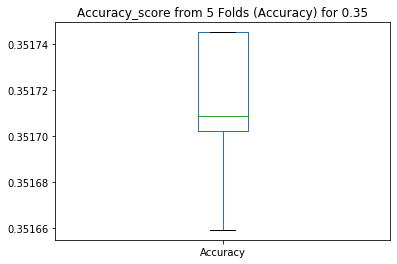

In [46]:
modelNB = MultinomialNB(alpha=1)

#### Hyper parameter ####
# alpha - Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

modelNB.fit(X_train, y_train)

nfolds=5
scores=cross_val_score(modelNB, X_Training_DS,y_Training_DS, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelNB.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))

## 3.1  k-nearest neighbors 

In [49]:
kvalue=[]
test_accuracy=[]
test_precision=[]
validation_accuracy=[]
validation_precision=[]
cross_accuray=[]


for k in [4,6,10,16,25,35]:
    modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    #### Hyper parameter ####
    # n_neighbors - Number of neighbors to use by default for kneighbors queries
    # weights - weight function used in prediction (‘distance’ : weight points by the inverse of their distance. 
    #in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.)
   
    modelKBC.fit(X_train, y_train)

    y_pred = modelKBC.predict(X_test)
    
    val_preds=modelKBC.predict(X_Validation_DS)
    validation_part['val_preds']=val_preds
    y_Validation_DS=validation_part[['val_preds','Category_1','Category_2']].apply(lambda x: x['Category_2'] if(x['Category_2']== x['val_preds']) else x['Category_1'] ,axis=1)

    kvalue.append(k)
    test_accuracy.append( round( metrics.accuracy_score(y_test,y_pred),2) )
    test_precision.append(round(metrics.precision_score(y_test,y_pred, average='macro'),2) )
    
    validation_accuracy.append( round(metrics.accuracy_score(y_Validation_DS,val_preds),2) )
    validation_precision.append( round(metrics.precision_score(y_Validation_DS,val_preds, average='macro'),2) )
    
    #nfolds=3
    #scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
    #pd.Series(scores).plot(kind="box", label="Accuracy");
    #plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))
    #cross_accuray
    
    print('neighbors:',k,'completed')


neighbors: 4 completed
neighbors: 6 completed
neighbors: 10 completed
neighbors: 16 completed
neighbors: 25 completed
neighbors: 35 completed


In [50]:
kNNResult=pd.DataFrame({'kvalue':kvalue, 'test_accuracy':test_accuracy,'test_precision':test_precision, 'validation_accuracy':validation_accuracy,'validation_precision':validation_precision  })
kNNResult

,kvalue,test_accuracy,test_precision,validation_accuracy,validation_precision
0,4,0.84,0.83,0.78,0.71
1,6,0.85,0.85,0.74,0.70
2,10,0.86,0.85,0.74,0.70
3,16,0.86,0.86,0.70,0.65
4,25,0.87,0.86,0.70,0.65
5,35,0.87,0.86,0.67,0.62


Text(0.5, 1.0, 'Accuracy_score from 3 Folds (Accuracy) for 0.83')

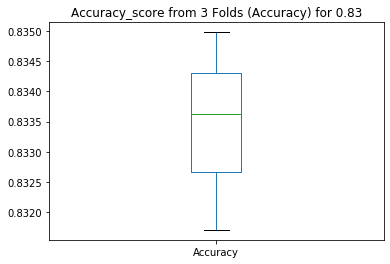

In [51]:
k=4
modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
modelKBC.fit(X_train, y_train)

y_pred = modelKBC.predict(X_test)

nfolds=3
scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

In [52]:
# Print the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=3))

[[1331   81  380   74]
 [  56 1811   59   94]
 [ 236   97 2259  177]
 [  66  117  216 3153]]
              precision    recall  f1-score   support

           0      0.788     0.713     0.749      1866
           1      0.860     0.897     0.878      2020
           2      0.775     0.816     0.795      2769
           3      0.901     0.888     0.894      3552

    accuracy                          0.838     10207
   macro avg      0.831     0.828     0.829     10207
weighted avg      0.838     0.838     0.838     10207



In [53]:
val_preds=modelKBC.predict(X_Validation_DS)
validation_part['val_preds']=val_preds
y_Validation_DS=validation_part[['val_preds','Category_1','Category_2']].apply(lambda x: x['Category_2'] if(x['Category_2']== x['val_preds']) else x['Category_1'] ,axis=1)


# Print the confusion matrix
print(metrics.confusion_matrix(y_Validation_DS, val_preds))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_Validation_DS, val_preds, digits=2))


[[10  0  0  0]
 [ 1  2  0  1]
 [ 1  1  1  0]
 [ 1  0  1  8]]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.67      0.50      0.57         4
           2       0.50      0.33      0.40         3
           3       0.89      0.80      0.84        10

    accuracy                           0.78        27
   macro avg       0.71      0.66      0.67        27
weighted avg       0.77      0.78      0.76        27



In [56]:
cvalue=[]
test_accuracy=[]
test_precision=[]
validation_accuracy=[]
validation_precision=[]
cross_accuray=[]


for x in [.01]+list(np.linspace(0.1,100,5))+[10]:

    modelSVC = svm.LinearSVC(C=x).fit(X_train, y_train)
    #### Hyper parameter ####
    # C - The strength of the regularization is inversely proportional to C.

    y_pred = modelSVC.predict(X_test)
    
    val_preds=modelSVC.predict(X_Validation_DS)
    validation_part['val_preds']=val_preds
    y_Validation_DS=validation_part[['val_preds','Category_1','Category_2']].apply(lambda x: x['Category_2'] if(x['Category_2']== x['val_preds']) else x['Category_1'] ,axis=1)

    cvalue.append(x)
    test_accuracy.append( round( metrics.accuracy_score(y_test,y_pred),2) )
    test_precision.append(round(metrics.precision_score(y_test,y_pred, average='macro'),2) )
    
    validation_accuracy.append( round(metrics.accuracy_score(y_Validation_DS,val_preds),2) )
    validation_precision.append( round(metrics.precision_score(y_Validation_DS,val_preds, average='macro'),2) )
    

/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/balaji/anaconda3/lib/python3.7/site-packag

In [57]:
SVCResult=pd.DataFrame({'cvalue':cvalue, 'test_accuracy':test_accuracy,'test_precision':test_precision, 'validation_accuracy':validation_accuracy,'validation_precision':validation_precision  })
SVCResult

,cvalue,test_accuracy,test_precision,validation_accuracy,validation_precision
0,0.010,0.86,0.85,0.41,0.10
1,0.100,0.86,0.86,0.41,0.10
2,25.075,0.86,0.86,0.41,0.10
3,50.050,0.86,0.86,0.41,0.10
4,75.025,0.85,0.84,0.41,0.10
5,100.000,0.81,0.82,0.41,0.10
6,10.000,0.86,0.86,0.48,0.36


## 4. Formatting the output categories based on the predict_proba

In [58]:
## Based on predict_proba result. reorder to values and categories based on high probablity.

def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_1']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_1']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_1']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_1']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_2']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_2']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_2']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_2']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelKBC.predict_proba(merged_data[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

In [59]:
PredictedValues.loc[PredictedValues['Category_3_Values']<=.15,'Category_3']=''
PredictedValues.loc[PredictedValues['Category_2_Values']<=.15,'Category_2']=''

PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_2']=''
PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_3']=''

In [60]:
PredictedValues['Category']=merged_data['Category']

fil_1_2=(PredictedValues['Category_12_Variance']<=.10) & ((PredictedValues['Category_1']==PredictedValues['Category']) | (PredictedValues['Category_2']==PredictedValues['Category']))
fil_2_3=(PredictedValues['Category_23_Variance']<=.10) & ((PredictedValues['Category_3']==PredictedValues['Category']) | (PredictedValues['Category_2']==PredictedValues['Category']))

PredictedValues.loc[(fil_1_2 | fil_2_3) ,'Category_1']=PredictedValues.loc[(fil_1_2 | fil_2_3) ,'Category']
PredictedValues.loc[(fil_1_2 | fil_2_3) ,'Category_2']=''
PredictedValues.loc[(fil_1_2 | fil_2_3) ,'Category_3']=''

## 5.1. Manual Validation

In [63]:
## regenerating dataset

NewMergedDSAligned=pd.concat([merged_data[merged_data.columns.tolist()[:12]+['ISOForestCluster']],PredictedValues[PredictedValues.columns[4:12]]], axis=1, ignore_index=False)

In [64]:
fil_1_2=(NewMergedDSAligned['Category_12_Variance']<=.10) & ((NewMergedDSAligned['Category_1']==NewMergedDSAligned['Category']) | (NewMergedDSAligned['Category_2']==NewMergedDSAligned['Category']))
fil_2_3=(NewMergedDSAligned['Category_23_Variance']<=.10) & ((NewMergedDSAligned['Category_3']==NewMergedDSAligned['Category']) | (NewMergedDSAligned['Category_2']==NewMergedDSAligned['Category']))

NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_1']=NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category']
NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_2']=''
NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_3']=''

In [66]:
NewMergedDSAligned['ISOForestCluster'].value_counts()

 1    40826
-1    10207
Name: ISOForestCluster, dtype: int64

In [65]:
#(NewMergedDSAligned.ISOForestCluster!=0) &

NewMergedDSAligned['ISOForestCluster'][ (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

-1    1504
 1     918
Name: ISOForestCluster, dtype: int64

In [67]:
NewMergedDSAligned['Category'][(NewMergedDSAligned.ISOForestCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

Natural Sciences                  490
Engineering Sciences              429
Life Sciences                     405
Humanities and Social Sciences    180
Name: Category, dtype: int64

In [ ]:
cats='Natural Sciences'
lim=20
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.ISOForestCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

In [ ]:
#cats='Humanities and Social Sciences'
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.ISOForestCluster!=1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()#.tail().

In [ ]:
#NewMergedDSAligned.to_csv(Path+'WEPCAISOFindingsKMeans.csv', index=False)

## 5.2. Validation with manual taggings

In [69]:
## regenerating dataset

MergeValidation=pd.concat([merged_data[['ISOForestCluster','Translates']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)
MergeValidationResult_2=manualtag[['Category','Translates', 'Category_1', 'Category_2','interdiscipilinary']].merge(MergeValidation,how='left', left_on='Translates', right_on='Translates',suffixes= ('_Actual','_Pred'))


## Function to take a better results for valudation
def rebuilt_ip(x):
    final_pred=x['Category_1_Pred']
    final_actual=x['Category_1_Actual']
    result=0
    
    if(x['Category_1_Pred'] == x['Category_1_Actual']):
        final_pred=x['Category_1_Pred']
        final_actual=x['Category_1_Actual']
        result=1
        
    elif(x['Category_1_Pred'] == x['Category_2_Actual']):
        final_pred=x['Category_1_Pred']
        final_actual=x['Category_2_Actual']
        result=1
    
    elif(x['Category_2_Pred'] == x['Category_1_Actual']):
        final_pred=x['Category_2_Pred']
        final_actual=x['Category_1_Actual']
        result=.66
        
    elif(x['Category_2_Pred'] == x['Category_2_Actual']):
        final_pred=x['Category_2_Pred']
        final_actual=x['Category_2_Actual']
        result=.66
        
    elif(x['Category_3'] == x['Category_1_Actual']):
        final_pred=x['Category_2_Pred']
        final_actual=x['Category_1_Actual'] 
        result=.33
        
    elif(x['Category_3'] == x['Category_2_Actual']):
        final_pred=x['Category_2_Pred']
        final_actual=x['Category_2_Actual']
        result=.33
    
    # if it is not an outlier assigning a original data sets
    if(x['ISOForestCluster']!=-1):
        final_pred=x['Category_Actual']
        final_actual=x['Category_1_Actual']
        result=-1
    
    return pd.Series({'pred':final_pred,'actual':final_actual,'result':result})

MergeValidationResult_3=pd.concat([MergeValidationResult_2,pd.DataFrame(MergeValidationResult_2.apply(rebuilt_ip, axis=1))], axis=1)
MergeValidationResult_3['Match']=MergeValidationResult_3.apply(lambda x: 'Correct' if(x['pred']==x['Category_Actual']) else 'interdiscipilinary' , axis=1)


In [70]:
MergeValidationResult_3.groupby(['ISOForestCluster','Match']).count()[['Translates']]

Translates
ISOForestCluster Match                         
-1               Correct                     13
                 interdiscipilinary          14
 1               Correct                     23

In [71]:
# Print the confusion matrix
print(metrics.confusion_matrix(MergeValidationResult_3.actual, MergeValidationResult_3.pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(MergeValidationResult_3.actual, MergeValidationResult_3.pred, digits=3))

[[11  0  0  2]
 [ 1  9  0  1]
 [ 1  4 11  2]
 [ 0  0  0  8]]
                                precision    recall  f1-score   support

          Engineering Sciences      0.846     0.846     0.846        13
Humanities and Social Sciences      0.692     0.818     0.750        11
                 Life Sciences      1.000     0.611     0.759        18
              Natural Sciences      0.615     1.000     0.762         8

                      accuracy                          0.780        50
                     macro avg      0.788     0.819     0.779        50
                  weighted avg      0.831     0.780     0.780        50



## 5.3. Each category TF/IDF based result evaluvation 

In [72]:
#&(NewMergedDSAligned['Category']==cats) &(NewMergedDSAligned['Category_1']==check_cat)

input_data=NewMergedDSAligned[(NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1']) & (NewMergedDSAligned.ISOForestCluster!=1) ]

input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1','Category_2','Category_3']].apply(lambda x:x[0]+','+x[1]+','+x[2]+','+x[3], axis=1)
#input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1']].apply(lambda x:x[0]+','+x[1], axis=1)
input_data.loc[:,'CategoryCollc']=input_data['CategoryCollc'].str.strip(",")

/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [73]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
varclusterall=varclusterall[varclusterall.RS_Ratio<.98]

In [74]:
def find_category(target_word):
    try :
        sim_word=list(map(lambda x:x[0] ,modelchecked.wv.most_similar(target_word, topn=5)))
        finalcategory=varclusterall[varclusterall.Variable.isin(sim_word)].category.value_counts().sort_values(ascending=False).head(1).index
        if(len(finalcategory)>0):
            return finalcategory[0]
        else:
            return np.NaN
    except :
        return np.NaN

In [75]:
sizes=len(input_data.CategoryCollc.unique())
category_tfidfs=pd.DataFrame()

with tqdm(total=len(input_data['CategoryCollc'].unique())) as bar:
    for i,bucket in input_data.groupby(['CategoryCollc']):
        varcat=pd.DataFrame()

        vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1, 1))
        review_vectors = vectorizer.fit_transform(bucket["PreProcessedDescription"])
        features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

        varcat=pd.DataFrame(features_df.sum().sort_values(ascending=False)).merge(varclusterall, how='left', left_index=True, right_on='Variable')[[0,'Variable','category']]
        varcat.category=varcat[['Variable', 'category']].apply(lambda x: find_category(x.Variable) if(pd.isnull(x['category'])) else x['category'], axis=1)

        varcat['bucket_length']=len(bucket)
        varcat['bucket_category']=bucket['Category'].unique()[0]
        varcat['Category_1']=bucket['Category_1'].unique()[0]
        varcat['Category_2']=bucket['Category_2'].unique()[0]
        varcat['Category_3']=bucket['Category_3'].unique()[0]

        varcat['Category_1_Score']=bucket['Category_1_Values'].mean()
        varcat['Category_2_Score']=bucket['Category_2_Values'].mean()
        varcat['Category_3_Score']=bucket['Category_3_Values'].mean()

        varcat=varcat.reset_index()

        category_tfidfs=pd.concat([varcat[varcat.columns[1:]],category_tfidfs])
        bar.update(1)

100%|██████████| 67/67 [00:20<00:00,  3.55it/s]


In [76]:
category_tfidfs.to_csv(Path+'CategoryTFIDFSummary_WEPCAISOForestFindingsKMeansV3.csv', index=False)

# Visualization

In [78]:
def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1


NewMergedDSAligned2=pd.concat([merged_data,PredictedValues[PredictedValues.columns[4:12]]], axis=1, ignore_index=False)

NewMergedDSAligned2.loc[:,'Category_1_ID']=NewMergedDSAligned2.Category_1.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_2_ID']=NewMergedDSAligned2.Category_2.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_3_ID']=NewMergedDSAligned2.Category_3.apply(CattoID)

NewMergedDSAligned2=pd.DataFrame(enumerate(NewMergedDSAligned2.SubjectArea.unique()), columns=['Subjectid','SubjectAreaMatching']).merge(NewMergedDSAligned2,left_on='SubjectAreaMatching', right_on='SubjectArea')

cats=['Engineering Sciences','Humanities and Social Sciences', 'Life Sciences','Natural Sciences']
cats_dist=[]

## Finiding the overall similiarity

for c, w in NewMergedDSAligned2[(NewMergedDSAligned2['Category']!=NewMergedDSAligned2['Category_1']) & (NewMergedDSAligned2['ISOForestCluster']!=1)].groupby('Category'):
    #print('')
    #print(c, len(w))
    #other_cat=list(filter(lambda x:x!=c, cats))
    cat_dist=[]
    for oc in cats:
        if oc==c:
            oc_sim=0
            
        else:
            oc_sum=sum(w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist())
            oc_sim=oc_sum/len(w)
            
        cat_dist.append(oc_sim)
        #print(c,':',oc,'-', round(oc_sim,2))
        
        #oc_sum=w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist()
        #oc_sim=sum(oc_sum)/len(oc_sum)
        #print(c,':',oc,'-', round(oc_sim,2))
    cats_dist.append(np.array(cat_dist))
cats_dist=np.array(cats_dist)

## Making symmetric matrix
sym_dist=np.zeros(cats_dist.shape)
for i in range(cats_dist.shape[0]):
    for j in range(cats_dist.shape[0]):
        sym_dist[i][j]=(cats_dist[i][j]+ cats_dist[j][i])/2
        if(i==j):
            sym_dist[i][j]=1

# 1-x : convert similiarity to distance
sym_dist=1-pd.DataFrame(sym_dist, columns=cats, index=cats)

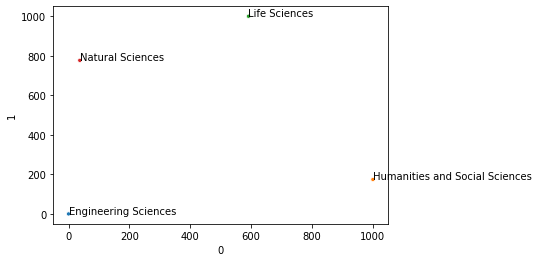

In [79]:
## Generating coordinates from distance

#, angle=0.8

#coords = TSNE(n_components=2,perplexity=.1, random_state=12, metric='precomputed').fit_transform(sym_dist)

#coords = TSNE(n_components=2,perplexity=4.2, random_state=18, metric='precomputed').fit_transform(sym_dist)
coords = PCA(n_components=2).fit_transform(sym_dist)

coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=cats).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="index",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
);

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], cats[line], horizontalalignment='left',  size='medium', color='black')

In [80]:
sym_dist

,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
Engineering Sciences,0.000000,0.796432,0.808755,0.570603
Humanities and Social Sciences,0.796432,0.000000,0.651005,0.850582
Life Sciences,0.808755,0.651005,0.000000,0.541497
Natural Sciences,0.570603,0.850582,0.541497,0.000000


In [81]:
newrange=pd.DataFrame(NewMergedDSAligned2.Category.value_counts()/80).reset_index().merge(coords,left_on='index',right_on='index')
newrange.loc[:,'Min_X']=newrange[0]-newrange['Category']
newrange.loc[:,'Max_X']=newrange[0]+newrange['Category']
newrange.loc[:,'Min_Y']=newrange[1]-(newrange['Category']*.60)
newrange.loc[:,'Max_Y']=newrange[1]+(newrange['Category']*.60)

newrange.columns=['Category','size', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']
newrange

,Category,size,0,1,Min_X,Max_X,Min_Y,Max_Y
0,Life Sciences,224.3625,591.186263,1000.000000,366.823763,815.548763,865.382500,1134.617500
1,Natural Sciences,171.5500,37.001179,776.748479,-134.548821,208.551179,673.818479,879.678479
2,Humanities and Social Sciences,124.8000,1000.000000,174.200980,875.200000,1124.800000,99.320980,249.080980
3,Engineering Sciences,117.2000,0.000000,0.000000,-117.200000,117.200000,-70.320000,70.320000


In [82]:
catsperplexity={'Engineering Sciences':5,'Humanities and Social Sciences':5, 'Life Sciences':10,'Natural Sciences':8}

## T-SNE separately for each categories

outerclusterfeatures=['Category_1_Values','Category_1_ID','Category_2_ID','Category_2_Values','Category_3_ID','Category_3_Values','Subjectid']
#Doc2VecModelData=pd.concat([pd.DataFrame(model.docvecs.vectors_docs),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
Doc2VecModelData=pd.concat([pd.DataFrame(pca[:,:10]),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
    
Doc2VecModelData['tsne-2d-one']=0
Doc2VecModelData['tsne-2d-two']=0

for cat in cats:#['Life Sciences']:#
    print(str(datetime.datetime.now()),'Started for', cat)
    
    tsne = TSNE(n_components=2, perplexity=catsperplexity[cat], n_iter=300, random_state=0, learning_rate=100)
    ## The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. 
    ## Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. 
    tsne_results = tsne.fit_transform(Doc2VecModelData[NewMergedDSAligned2.Category==cat])
    
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-one'] = tsne_results[:,0]
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-two'] = tsne_results[:,1]
    
    print(str(datetime.datetime.now()),'Completed for', cat)

Doc2VecModelData.loc[:,'Category'] = NewMergedDSAligned2.Category
Doc2VecModelData.loc[:,'Category_1'] = NewMergedDSAligned2.Category_1


2020-02-23 15:23:58.427544 Started for Engineering Sciences
2020-02-23 15:24:21.650846 Completed for Engineering Sciences
2020-02-23 15:24:21.651311 Started for Humanities and Social Sciences
2020-02-23 15:24:58.162134 Completed for Humanities and Social Sciences
2020-02-23 15:24:58.162323 Started for Life Sciences
2020-02-23 15:25:49.551593 Completed for Life Sciences
2020-02-23 15:25:49.552266 Started for Natural Sciences
2020-02-23 15:26:29.798790 Completed for Natural Sciences


In [83]:
# Reshaping
for cat in cats:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-one']=model_x.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-one']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-two']=model_y.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-two']])


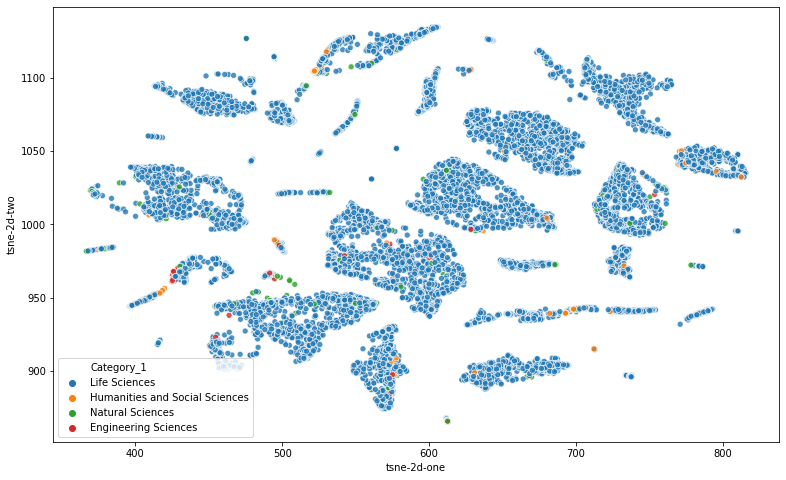

In [84]:
cat='Life Sciences'#'Engineering Sciences'#'Life Sciences'#'Humanities and Social Sciences'#'Life Sciences'#'
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData[Doc2VecModelData.Category==cat],
        legend="full",
#        style='Category_1',
        alpha=0.8
    );

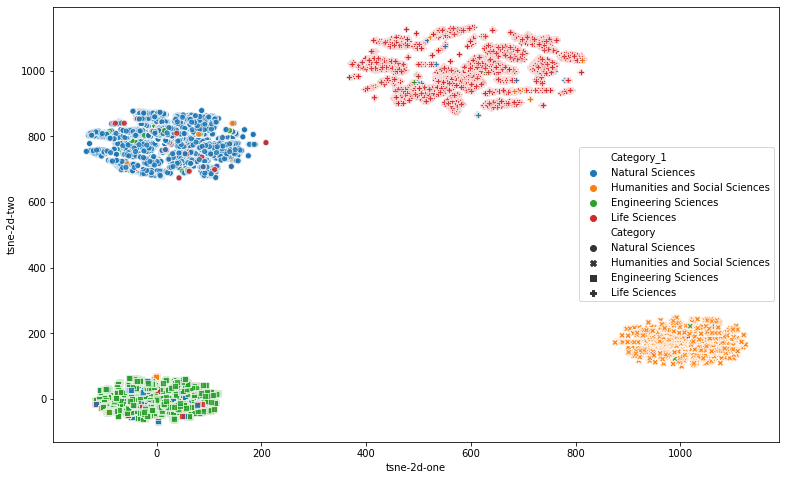

In [85]:
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData,
        legend="full",
        style='Category',
        alpha=0.8
    );

In [86]:
def label_genarator(input):
    if((input.Category==input.Category_1) or (input.ISOForestCluster==1)):
        return ''#'Category : '+input.Category
    else:
        if((input.Category_3_Values==0) and (input.Category_2_Values==0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%'+')'
        elif((input.Category_3_Values==0) and (input.Category_2_Values!=0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%)'
        else:
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%, '+input.Category_3+' '+str(round(input.Category_3_Values*100))+'%)'
        
        
Report_extrat=pd.concat([NewMergedDSAligned2[['Name','Institution','FundingFrom','FundingEnd', 'Category','Category_1_Values','Category_2_Values','Category_3_Values','Category_1','Category_2','Category_3','ISOForestCluster']],Doc2VecModelData[['tsne-2d-one', 'tsne-2d-two']]], axis=1)
Report_extrat['ProjectURL']=NewMergedDSAligned2.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)
Report_extrat['label']=Report_extrat.apply(label_genarator, axis=1)
Report_extrat['interdiscipilinary']=False
Report_extrat.loc[(Report_extrat.label!='') & (Report_extrat['ISOForestCluster']!=1),'interdiscipilinary']=True

In [87]:
Report_extrat['color']=Report_extrat['Category']
Report_extrat.loc[Report_extrat['interdiscipilinary'],'color']=Report_extrat.loc[Report_extrat['interdiscipilinary'],'Category_1']

In [88]:
Report_extrat.to_csv(Path+'Report_WEPCAISOForestFindingsKMeansV3.csv', index=False)
newrange.to_csv(Path+'CATRANGE_WEPCAISOForestFindingsKMeansV3.csv', index=False)